![Deep Learning for Scientists in a hurry](./fig/Title.png)

In [1]:
%load_ext watermark

In [2]:
%watermark

Last updated: 2023-07-24T23:09:06.740258-04:00

Python implementation: CPython
Python version       : 3.10.6
IPython version      : 8.14.0

Compiler    : GCC 11.3.0
OS          : Linux
Release     : 3.10.0-1160.24.1.el7.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 52
Architecture: 64bit



In [3]:
import time
start = time.time()
chapter_number = 1
import matplotlib
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from torchvision import models
from torchvision import transforms
from PIL import Image

import torch
import torch.nn as nn

In [5]:
%watermark -iv

matplotlib : 3.7.1
torchvision: 0.16.0a0
torch      : 2.1.0a0+4136153
PIL        : 9.2.0
numpy      : 1.22.2



---

# Pretrained Generative Adversarial Networks (GAN)

Another kind of Deep Neural network is the Generative Adversarial Networks. In GANs we have two Networks, one of them called the "Generator" generates images that try to fit into a certain class. The other network is called "Discrimitator" and will accept or refuse the image as being of the class and will inform the Generator. 

In a recursive cycle, the generator became better and better at generating images that could pass the Discriminator.

An evolution of the GAN is CycleGAN, in this case, we have 2 Generators and 2 Discriminators. The generators will convert images from one class to another and the other generator will convert from the second class into the first class. The two discriminators will control the proficiency of the generators by changing instances from one class to the other class.

![CycleGAN](./fig/CycleGAN.png)

The paper presenting the idea is [here](https://openaccess.thecvf.com/content_ICCV_2017/papers/Zhu_Unpaired_Image-To-Image_Translation_ICCV_2017_paper.pdf)

## Neural Network that converts Horses into Zebras

We will use a Neural network that was trained to recognize horses and convert them into zebras.
This network was taken from the Book [Deep Learning with PyTorch](https://www.manning.com/books/deep-learning-with-pytorch) by Eli Stevens, Luca Artiga, and Thomas Viehmann.

Lets skip the internals of this network. It is a black box for us at the moment. It helps to offer a glimpse of some recurrent words like `Conv2d` and `ReLU`. These words will be recurrent as we learn more about Convolutional Networks.

In [6]:
class ResNetBlock(nn.Module): # <1>

    def __init__(self, dim):
        super(ResNetBlock, self).__init__()
        self.conv_block = self.build_conv_block(dim)

    def build_conv_block(self, dim):
        conv_block = []

        conv_block += [nn.ReflectionPad2d(1)]

        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=0, bias=True),
                       nn.InstanceNorm2d(dim),
                       nn.ReLU(True)]

        conv_block += [nn.ReflectionPad2d(1)]

        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=0, bias=True),
                       nn.InstanceNorm2d(dim)]

        return nn.Sequential(*conv_block)

    def forward(self, x):
        out = x + self.conv_block(x) # <2>
        return out


class ResNetGenerator(nn.Module):

    def __init__(self, input_nc=3, output_nc=3, ngf=64, n_blocks=9): # <3> 

        assert(n_blocks >= 0)
        super(ResNetGenerator, self).__init__()

        self.input_nc = input_nc
        self.output_nc = output_nc
        self.ngf = ngf

        model = [nn.ReflectionPad2d(3),
                 nn.Conv2d(input_nc, ngf, kernel_size=7, padding=0, bias=True),
                 nn.InstanceNorm2d(ngf),
                 nn.ReLU(True)]

        n_downsampling = 2
        for i in range(n_downsampling):
            mult = 2**i
            model += [nn.Conv2d(ngf * mult, ngf * mult * 2, kernel_size=3,
                                stride=2, padding=1, bias=True),
                      nn.InstanceNorm2d(ngf * mult * 2),
                      nn.ReLU(True)]

        mult = 2**n_downsampling
        for i in range(n_blocks):
            model += [ResNetBlock(ngf * mult)]

        for i in range(n_downsampling):
            mult = 2**(n_downsampling - i)
            model += [nn.ConvTranspose2d(ngf * mult, int(ngf * mult / 2),
                                         kernel_size=3, stride=2,
                                         padding=1, output_padding=1,
                                         bias=True),
                      nn.InstanceNorm2d(int(ngf * mult / 2)),
                      nn.ReLU(True)]

        model += [nn.ReflectionPad2d(3)]
        model += [nn.Conv2d(ngf, output_nc, kernel_size=7, padding=0)]
        model += [nn.Tanh()]

        self.model = nn.Sequential(*model)

    def forward(self, input): # <3>
        return self.model(input)

In [7]:
netG = ResNetGenerator()

## Loading the pre-trained model

In [8]:
model_path = './data/horse2zebra_0.4.0.pth'
model_data = torch.load(model_path)
netG.load_state_dict(model_data);

## Setting the model in evaluation mode

Now we need to set the network in *Evaluation* mode. That will disable *batch normalizations* and *dropouts*. Those are used during training but not during evaluation.

In [9]:
netG.eval()

ResNetGenerator(
  (model): Sequential(
    (0): ReflectionPad2d((3, 3, 3, 3))
    (1): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1))
    (2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (3): ReLU(inplace=True)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (8): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (9): ReLU(inplace=True)
    (10): ResNetBlock(
      (conv_block): Sequential(
        (0): ReflectionPad2d((1, 1, 1, 1))
        (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
        (2): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (3): ReLU(inplace=True)
        (4): ReflectionPad2d((1, 1, 1, 1))
     

## Preprocessing the images

In [10]:
preprocess = transforms.Compose([transforms.Resize(256),
                                 transforms.ToTensor()])

We have two images found on [The page of Wikipedia for Horse](https://en.wikipedia.org/wiki/Horse)

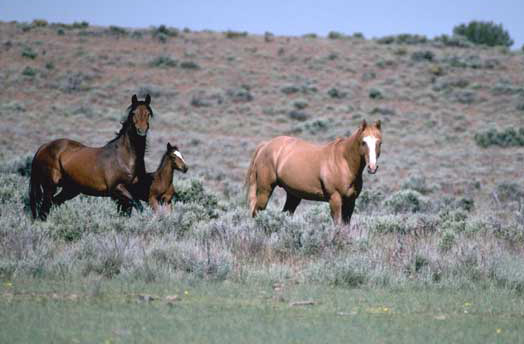

In [11]:
img1 = Image.open("./data/Horsescd1l-095.jpg")
img1

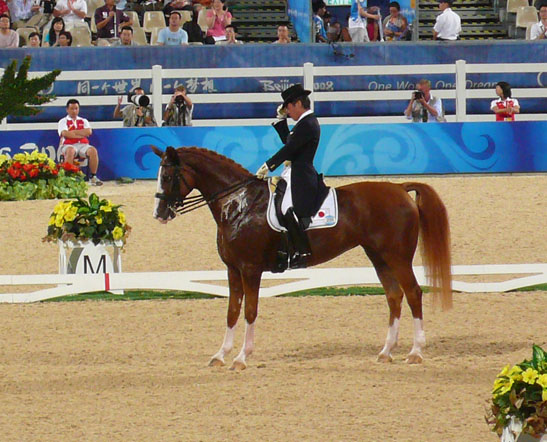

In [12]:
img2 = Image.open("./data/Beijing2008_HOKETSU_Hiroshi.JPG")
img2

We need to convert the image into a PyTorch Tensor and add the extra dimension associated with the batch.
In this case, we will keep one tensor for each image, ie the batch size continues to be 1.

In [13]:
img1_t = preprocess(img1)
batch1_t = torch.unsqueeze(img1_t, 0)

In [14]:
img2_t = preprocess(img2)
batch2_t = torch.unsqueeze(img2_t, 0)

## Running the inference

In [15]:
batch1_out = netG(batch1_t)
batch2_out = netG(batch2_t)

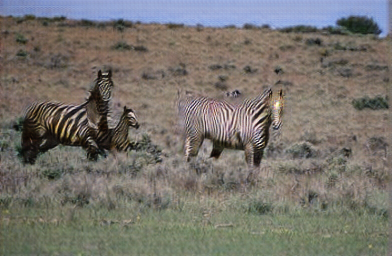

In [16]:
out1_t = (batch1_out.data.squeeze() + 1.0) / 2.0
out1_img = transforms.ToPILImage()(out1_t)
out1_img

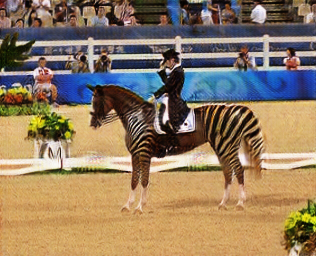

In [17]:
out2_t = (batch2_out.data.squeeze() + 1.0) / 2.0
out2_img = transforms.ToPILImage()(out2_t)
out2_img

# Exercises

1. Search over the internet the photo of a horse and upload it. Use the network to convert it into a zebra?

2. What happens if you try to convert a photo with a zebra?


---

# References

There are many books about Deep Learning and many more on Machine Learning. 
This list is by no means an exhaustive list of books. I am listing the books from which I took inspiration. Also, I am listing materials where I found better ways to present topics. Often I am amazed by how people can create approachable materials for seemingly dry subjects.

The order of the books goes from divulgation and practical to the more rigorous and mathematical. Slides, blogs, and videos are those I have found over the internet or suggested by others.

### Selection of Books on Deep Learning

<br>
<div style="clear: both; display: table;">
  <div style="border: none; float: left; width: 200; padding: 5px">
  <img alt="Deep Learning - Kelleher" 
       src="./fig/books/Deep Learning - Kelleher.jpg" 
       height="100" width="100"  />
  </div>
  <div style="border: none; float: left; width: 800; padding: 5px">
      Deep Learning<br>
      John D. Kelleher<br>
      2019<br>
  </div>
</div>

<br>
<div style="clear: both; display: table;">
  <div style="border: none; float: left; width: 200; padding: 5px">
  <img alt="Introduction to Deep Learning - Charniak" 
       src="./fig/books/Introduction to Deep Learning - Charniak.jpg" 
       height="100" width="100"  />
  </div>
  <div style="border: none; float: left; width: 800; padding: 5px">
      Introduction to Deep Learning<br>
      Eugene Charniak<br>
      2018<br>
  </div>
</div>

<br>
<div style="clear: both; display: table;">
  <div style="border: none; float: left; width: 200; padding: 5px">
  <img alt="Introduction to Deep Learning - Skansi" 
       src="./fig/books/Introduction to Deep Learning - Skansi.jpg" 
       height="100" width="100"  />
  </div>
  <div style="border: none; float: left; width: 800; padding: 5px">
      Introduction to Deep Learning<br>
      Sandro Skansi<br>
      2018<br>
  </div>
</div>

<br>
<div style="clear: both; display: table;">
  <div style="border: none; float: left; width: 200; padding: 5px">
  <img alt="Deep Learning with PyTorch - Subramanian" 
       src="./fig/books/Deep Learning with PyTorch - Subramanian.jpg" 
       height="100" width="100"  />
  </div>
  <div style="border: none; float: left; width: 800; padding: 5px">
      Deep Learning with PyTorch<br>
      Vishnu Subramanian<br>
      2018<br>
  </div>
</div>

<br>
<div style="clear: both; display: table;">
  <div style="border: none; float: left; width: 200; padding: 5px">
  <img alt="Deep Learning with PyTorch - Stevens" 
       src="./fig/books/Deep Learning with PyTorch - Stevens.png" 
       height="100" width="100"  />
  </div>
  <div style="border: none; float: left; width: 800; padding: 5px">
      Deep Learning with PyTorch<br>
      Eli Stevens, Luca Artiga and Thomas Viehmann<br>
      2020<br>
  </div>
</div>

<br>
<div style="clear: both; display: table;">
  <div style="border: none; float: left; width: 200; padding: 5px">
  <img alt="Deep Learning with Python - Chollet" 
       src="./fig/books/Deep Learning with Python - Chollet.jpg" 
       height="100" width="100" />
  </div>
  <div style="border: none; float: left; width: 800; padding: 5px">
      Deep Learning with Python (Second Edition)<br>
      François Chollet<br>
      2021<br>
  </div>
</div>

<br>
<div style="clear: both; display: table;">
  <div style="border: none; float: left; width: 200; padding: 5px">
  <img alt="Deep Learning - Patterson" 
       src="./fig/books/Deep Learning - Patterson.jpeg"
       height="100" width="100" />
  </div>
  <div style="border: none; float: left; width: 800; padding: 5px">
      Deep Learning, a practitioner's approach<br>
      Josh Patterson and Adam Gibson<br>
      2017<br>
  </div>
</div>

<br>
<div style="clear: both; display: table;">
  <div style="border: none; float: left; width: 200; padding: 5px">
  <img alt="Deep Learning - Goodfellow" 
       src="./fig/books/Deep Learning - Goodfellow.jpg" 
       height="100" width="100"  />
  </div>
  <div style="border: none; float: left; width: 800; padding: 5px">
      Deep Learning<br>
      Ian Goodfellow, Yoshua Bengio, and Aaron Courville<br>
      2016<br>
  </div>
</div>

### Interactive Books

  * [Dive into Deep Learning](https://d2l.ai/index.html)<br>
    Interactive deep learning book with code, math, and discussions<br> 
    Implemented with PyTorch, NumPy/MXNet, and TensorFlow<br>
    Adopted at 300 universities from 55 countries


### Slides

  * John Urbanic's ["Deep Learning in one Afternoon"](https://www.psc.edu/wp-content/uploads/2022/04/Deep-Learning.pdf)<br>
An excellent fast, condensed introduction to Deep Learning.<br>
John is a Parallel Computing Scientist at Pittsburgh Supercomputing Center

  * [Christopher Olah's Blog](http://colah.github.io) is very good. For example about [Back Propagation](http://colah.github.io/posts/2015-08-Backprop)

  * Adam W. Harley on his CMU page offers [An Interactive Node-Link Visualization of Convolutional Neural Networks](https://www.cs.cmu.edu/~aharley/vis/)



### Jupyter Notebooks

 * [Yale Digital Humanities Lab](https://github.com/YaleDHLab/lab-workshops)
 
 * Aurelien Geron Hands-on Machine Learning with Scikit-learn 
   [First Edition](https://github.com/ageron/handson-ml) and
   [Second Edition](https://github.com/ageron/handson-ml2)
   
 * [A progressive collection notebooks of the Machine Learning course by the University of Turin](https://github.com/rugantio/MachineLearningCourse)
   
 * [A curated set of jupyter notebooks about many topics](https://github.com/jupyter/jupyter/wiki/A-gallery-of-interesting-Jupyter-Notebooks)
   
### Videos

 * [Caltech's "Learning from Data" by Professor Yaser Abu-Mostafa](https://work.caltech.edu/telecourse.html)
 
 * [3Blue1Brown Youtube Channel](https://www.youtube.com/watch?v=Ilg3gGewQ5U)
 
 ---

# Back of the Book

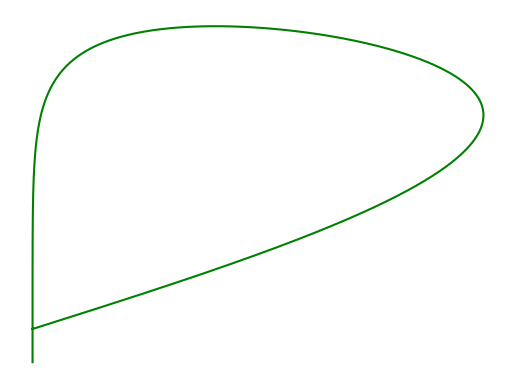

In [18]:
n = chapter_number
t = np.linspace(0, (2*(n-1)+1)*np.pi/2, 1000)
x = t*np.cos(t)**3
y = 9*t*np.sqrt(np.abs(np.cos(t))) + t*np.sin(0.3*t)*np.cos(2*t)
plt.plot(x, y, c="green")
plt.axis('off');

In [19]:
end = time.time()
print(f'Chapter {chapter_number} took {int(end - start):d} seconds')

Chapter 1 took 2 seconds
